In [1]:
#import comet_ml
import sys
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from baselines.utils.inter_utils import *
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader, Dataset
device = get_device()
import warnings
import cv2
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

#experiment = comet_ml.Experiment(
#    api_key="7foLFXCsKacyXf6RiMlUoFULq",
#    project_name="Parking_occupancy"
#)

Using CPU
Recommend using GPU for faster training


## My utils functions

In [2]:
def show_from_dataset(n, train_data_loader):
    i = 0
    for images, targets, image_ids in train_data_loader:
        image = images
        target = targets
        image_id = image_ids
        if i == n:
            break
        i +=1
    pred_boxes = [[(x[0], x[1]), (x[2], x[3])] for x in list(targets[0]["boxes"].detach().numpy())]
    image = image[0].permute(1,2,0)
    image = image.detach().numpy()
    for x in pred_boxes:
        cv2.rectangle(image, (int(x[0][0]),int(x[0][1])), (int(x[1][0]),int(x[1][1])), color=(255, 0, 0), thickness=2)
    fig = plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.axis("off")
    
def make_pred(model, img_batch, treshold):
    pred = model(img_batch)
    pred_boxes = [[(x[0], x[1]), (x[2], x[3])] for x in list(pred[0]["boxes"].detach().numpy())]
    pred_class = list(pred[0]["labels"].detach().numpy())
    pred_score = list(pred[0]["scores"].detach().numpy())
    try:
        over_treshold = [pred_score.index(x) for x in pred_score if x>treshold][-1]
    except IndexError:
        raise ValueError("No detection above threshold")
    pred_boxes = pred_boxes[:over_treshold+1]
    pred_class = pred_class[:over_treshold+1]
    return pred_boxes, pred_score

def show_inference(img_batch, model, img, treshold):
    boxes, score = make_pred(model, img_batch, treshold)
    for i, x in enumerate(boxes):
        cv2.rectangle(img, (int(x[0][0]),int(x[0][1])), (int(x[1][0]),int(x[1][1])), color=(255, 0, 0), thickness=2)
        cv2.putText(img, str(score[i]), (int(x[0][0]),int(x[0][1])), cv2.LINE_AA, 1.2, (255,0,0), 1)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.axis("off")

In [3]:
#Settings
#Instead of using argparse set the arguments here
min_size = 300
max_size = 500
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class settings:
    dataframe = "datasets/T10LOT/T10LOT/T10LOT_dataframe.csv"
    path =  "datasets/T10LOT/T10LOT"
    model_type = "retinanet_resnet"
    batch_size = 1

In [4]:
seed_everything(seed=420)
args = settings()

if args.model_type == 'faster_rcnn_mobilenet':
    model = get_model(faster_rcnn_mobilenet_params)
elif args.model_type == 'faster_rcnn_resnet':
    model = get_model(faster_rcnn_resnet_params)
elif args.model_type == 'faster_rcnn_vgg':
    model = get_model(faster_rcnn_vgg_params)
elif args.model_type == 'retinanet_mobilenet':
    model = get_model(retinanet_mobilenet_params)
elif args.model_type == 'retinanet_resnet':
    model = get_model(retinanet_resnet_params)
elif args.model_type == 'retinanet_vgg':
    model = get_model(retinanet_vgg_params)
else:
    raise Exception('Invalid model type')

model.to(device);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


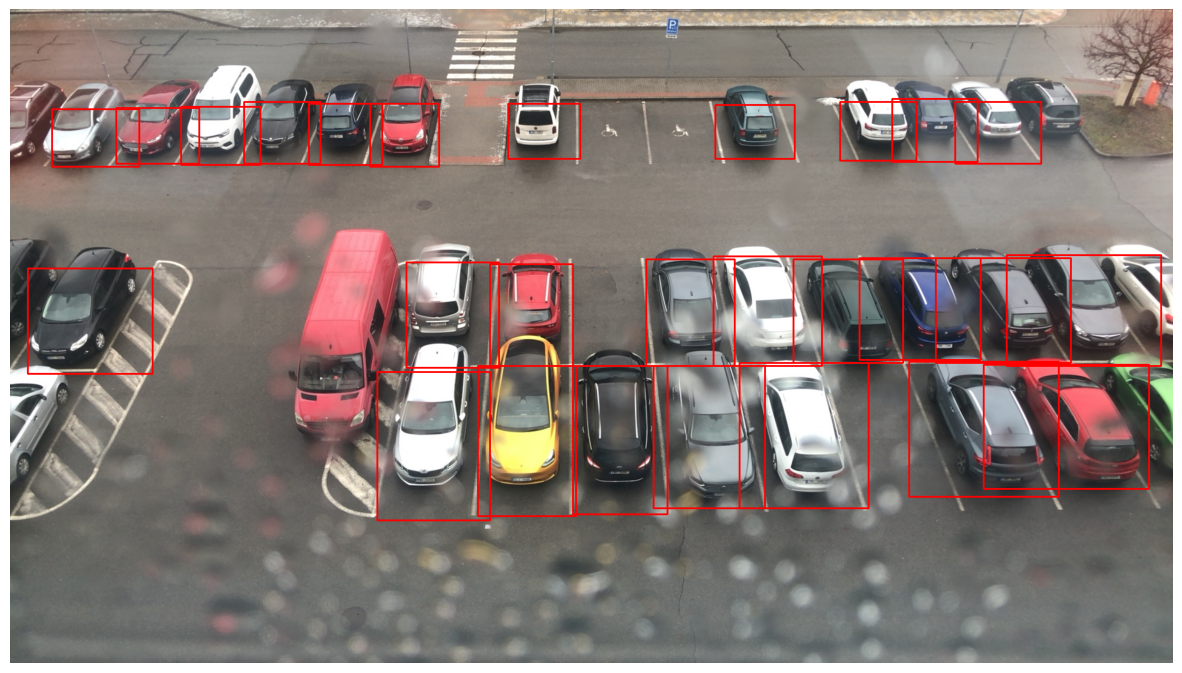

In [7]:
DIR_INPUT = os.path.join(args.path, 'splitted_images/')
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAL = f'{DIR_INPUT}/val'
DIR_TEST = f'{DIR_INPUT}/test'

dataframe = pd.read_csv(args.dataframe)

train_df, valid_df = get_dataframes(dataframe)

# dataloaders
train_dataset = ParkDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = ParkDataset(valid_df, DIR_VAL, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler_increase = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10.0)
lr_scheduler_decrease = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 100

#show_from_dataset(1, valid_data_loader)

#train_inter_model(model, num_epochs, train_data_loader, valid_data_loader, device)
#experiment.end()

# Inference

Using CPU
Recommend using GPU for faster training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: No detection above threshold

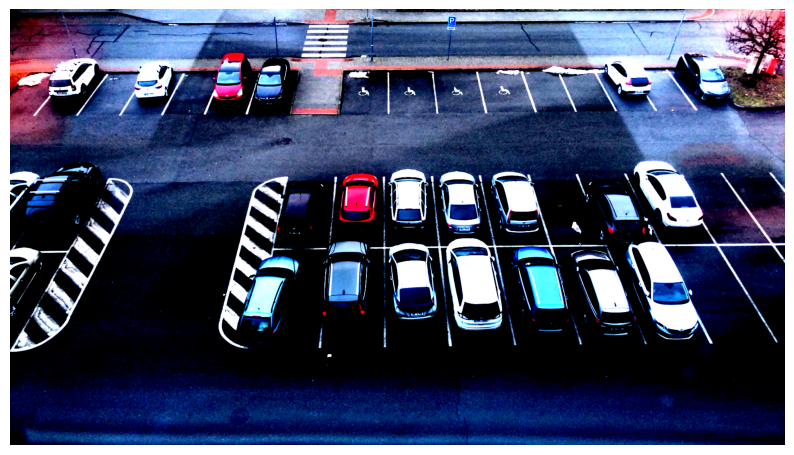

In [13]:
from torchvision import transforms

device = get_device()
model = get_model(faster_rcnn_mobilenet_params)
model.eval()
model.load_state_dict(torch.load("Saved_Models/state_dict_34.pth", map_location=torch.device('cpu')))
image = cv2.imread("datasets/T10LOT/T10LOT/splitted_images/train/Picture0084.jpg", cv2.IMREAD_COLOR).astype(np.float32)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

preprocess = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    #transforms.Normalize(mean=mean, std=std),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
plt.figure(figsize=(10,10))
plt.imshow(input_batch[0].permute(1,2,0))
plt.axis("off")

with torch.no_grad():
    input_batch = input_batch.to(device)
    show_inference(input_batch, model, image, 0.5)